# Lid-Driven Cavity case (LDC)

This test case considers a box with a moving lid, where the velocity is initially at rest.

We start by loading IncompressibleNavierStokes and a Makie plotting backend.

In [1]:
using IncompressibleNavierStokes

if haskey(ENV, "GITHUB_ACTIONS")
    using CairoMakie
else
    using GLMakie
end

## Build problem

We may choose the floating point type for the simulations. Replacing `Float64` with
`Float32` will not necessarilily speed up the simulations, but requires half as much
memory.

In [2]:
T = Float64

Float64

Available viscosity models are:

- `LaminarModel`,
- `KEpsilonModel`,
- `MixingLengthModel`,
- `SmagorinskyModel`, and
- `QRModel`.

They all take a Reynolds number as a parameter. Here we choose a moderate Reynolds number.

In [3]:
viscosity_model = LaminarModel{T}(; Re = 1000)

LaminarModel{Float64}(1000.0)

Available convection models are:

- `NoRegConvectionModel`,
- `C2ConvectionModel`,
- `C4ConvectionModel`, and
- `LerayConvectionModel`.

We here take the simplest model.

In [4]:
convection_model = NoRegConvectionModel{T}()

NoRegConvectionModel{Float64}()

We create a two-dimensional domain with a box of size `[1, 1]`. We add a slight scaling
factor of 95% to increase the precision near the moving lid.

In [5]:
x = cosine_grid(0.0, 1.0, 50)
y = stretched_grid(0.0, 1.0, 50, 0.95)
grid = create_grid(x, y; T)

Grid{Float64, 2}(false, 81.0, 1.125, 50, 50, 1, (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), [0.0, 0.0009866357858642205, 0.003942649342761062, 0.00885637463565564, 0.015708419435684462, 0.024471741852423234, 0.03511175705587427, 0.04758647376699027, 0.06184665997806821, 0.07783603724899246  …  0.9221639627510074, 0.9381533400219317, 0.9524135262330098, 0.9648882429441257, 0.9755282581475768, 0.9842915805643155, 0.9911436253643443, 0.9960573506572389, 0.9990133642141358, 1.0], [0.0, 0.054167951704709075, 0.10562750582418264, 0.15451408223768262, 0.20095632983050743, 0.24507646504369132, 0.28699059349621575, 0.3268090155261141, 0.3646365164545174, 0.40057264233650064  …  0.9510954685787368, 0.9577086468545091, 0.9639911662164926, 0.969959559610377, 0.9756295333345673, 0.981016008372548, 0.9861331596586296, 0.990994453380407, 0.9956126824160958, 1.0], Float64[], [0.0004933178929321103, 0.0024646425643126413, 0.006399511989208351, 0.01228239703567005, 0.020090080644053848, 0.029791749454148753, 0.

The grid may be visualized using the `plot_grid` function.

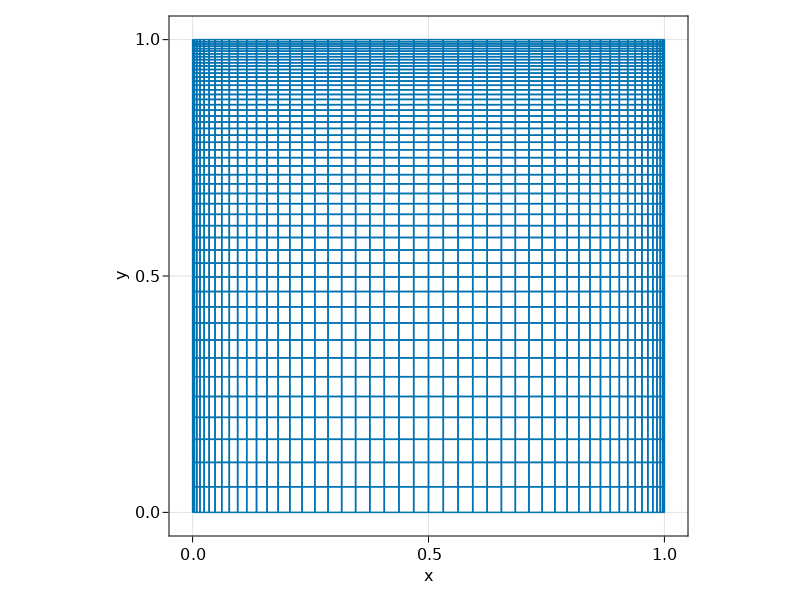

In [6]:
plot_grid(grid)

Dirichlet boundary conditions are specified as plain Julia functions. They are marked by
the `:dirichlet` symbol. Other possible BC types are `:periodic`, `:symmetric`, and `:pressure`.

In [7]:
u_bc(x, y, t) = y ≈ grid.ylims[2] ? 1.0 : 0.0
v_bc(x, y, t) = zero(x)
bc = create_boundary_conditions(
    u_bc,
    v_bc;
    bc_unsteady = false,
    bc_type = (;
        u = (; x = (:dirichlet, :dirichlet), y = (:dirichlet, :dirichlet)),
        v = (; x = (:dirichlet, :dirichlet), y = (:dirichlet, :dirichlet)),
    ),
    T,
)

BC{Float64}(false, (x = (:dirichlet, :dirichlet), y = (:dirichlet, :dirichlet)), (x = (:dirichlet, :dirichlet), y = (:dirichlet, :dirichlet)), NamedTuple(), NamedTuple(), NamedTuple(), NamedTuple(), Main.##292.u_bc, Main.##292.v_bc, IncompressibleNavierStokes.var"#93#117"(), IncompressibleNavierStokes.var"#94#118"(), IncompressibleNavierStokes.var"#95#119"(), IncompressibleNavierStokes.var"#96#120"(), (x = (0.0, 0.0), y = (0.0, 0.0)), (x = (0.0, 0.0), y = (0.0, 0.0)), (x = (0.0, 0.0), y = (0.0, 0.0)))

The body forces are specified as plain Julia functions.

In [8]:
bodyforce_u(x, y) = 0
bodyforce_v(x, y) = 0
force = SteadyBodyForce{T}(; bodyforce_u, bodyforce_v)

SteadyBodyForce{Float64}(Main.##292.bodyforce_u, Main.##292.bodyforce_v, IncompressibleNavierStokes.var"#22#34"(), Float64[])

We also choos a pressure solver. The direct solver will precompute the LU decomposition of
the Poisson matrix.

In [9]:
pressure_solver = DirectPressureSolver{T}()

DirectPressureSolver{Float64}(SuiteSparse.CHOLMOD.Factor{Float64}
type:    LLt
method:  simplicial
maxnnz:  1
nnz:     0
success: true
)

We may now assemble our setup.

In [10]:
setup = Setup{T,2}(; viscosity_model, convection_model, grid, force, pressure_solver, bc)

Setup{Float64, 2}(LaminarModel{Float64}(1000.0), NoRegConvectionModel{Float64}(), Grid{Float64, 2}(false, 81.0, 1.125, 50, 50, 1, (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), [0.0, 0.0009866357858642205, 0.003942649342761062, 0.00885637463565564, 0.015708419435684462, 0.024471741852423234, 0.03511175705587427, 0.04758647376699027, 0.06184665997806821, 0.07783603724899246  …  0.9221639627510074, 0.9381533400219317, 0.9524135262330098, 0.9648882429441257, 0.9755282581475768, 0.9842915805643155, 0.9911436253643443, 0.9960573506572389, 0.9990133642141358, 1.0], [0.0, 0.054167951704709075, 0.10562750582418264, 0.15451408223768262, 0.20095632983050743, 0.24507646504369132, 0.28699059349621575, 0.3268090155261141, 0.3646365164545174, 0.40057264233650064  …  0.9510954685787368, 0.9577086468545091, 0.9639911662164926, 0.969959559610377, 0.9756295333345673, 0.981016008372548, 0.9861331596586296, 0.990994453380407, 0.9956126824160958, 1.0], Float64[], [0.0004933178929321103, 0.0024646425643126413, 0.00639

The discrete operators are built with the `build_operators!` function.

In [11]:
build_operators!(setup)

Setup{Float64, 2}(LaminarModel{Float64}(1000.0), NoRegConvectionModel{Float64}(), Grid{Float64, 2}(false, 81.0, 1.125, 50, 50, 1, (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), [0.0, 0.0009866357858642205, 0.003942649342761062, 0.00885637463565564, 0.015708419435684462, 0.024471741852423234, 0.03511175705587427, 0.04758647376699027, 0.06184665997806821, 0.07783603724899246  …  0.9221639627510074, 0.9381533400219317, 0.9524135262330098, 0.9648882429441257, 0.9755282581475768, 0.9842915805643155, 0.9911436253643443, 0.9960573506572389, 0.9990133642141358, 1.0], [0.0, 0.054167951704709075, 0.10562750582418264, 0.15451408223768262, 0.20095632983050743, 0.24507646504369132, 0.28699059349621575, 0.3268090155261141, 0.3646365164545174, 0.40057264233650064  …  0.9510954685787368, 0.9577086468545091, 0.9639911662164926, 0.969959559610377, 0.9756295333345673, 0.981016008372548, 0.9861331596586296, 0.990994453380407, 0.9956126824160958, 1.0], Float64[], [0.0004933178929321103, 0.0024646425643126413, 0.00639

We will solve for a time interval of ten seconds.

In [12]:
t_start, t_end = tlims = (0.0, 10.0)

(0.0, 10.0)

The initial conditions are defined as plain Julia functions.

In [13]:
initial_velocity_u(x, y) = 0
initial_velocity_v(x, y) = 0
initial_pressure(x, y) = 0
V₀, p₀ = create_initial_conditions(
    setup,
    t_start;
    initial_velocity_u,
    initial_velocity_v,
    initial_pressure,
)

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.01864654927119828, 0.018647521966973033, 0.018655280398629008, 0.01868133365053201, 0.018742646892376195, 0.01886126744736161, 0.019063802644231465, 0.019380734580804956, 0.019845559543119597, 0.020493746091182142  …  0.6483667008758404, 0.7117332516406549, 0.7831253920958854, 0.8648377251463941, 0.9602347028573306, 1.0744660049361552, 1.2154673628475279, 1.3929207882549823, 1.6015884543829664, 1.7703299225218916])

## Solve problems

There are many different problems. They can all be solved by calling the `solve`
function.

A `SteadyStateProblem` is for computing a state where the right hand side of the
momentum equation is zero.

In [14]:
problem = SteadyStateProblem(setup, V₀, p₀)
V, p = @time solve(problem)

Initial momentum residual = 0.014185227352323077
Iteration 1: momentum residual = 0.0007103728974534346
Iteration 2: momentum residual = 0.0003605308524940867
Iteration 3: momentum residual = 0.00036968624780195223
Iteration 4: momentum residual = 0.00021275548611371657
Iteration 5: momentum residual = 4.1793701393381076e-5
Iteration 6: momentum residual = 6.605212993155714e-6
Iteration 7: momentum residual = 7.667950405789705e-9
Iteration 8: momentum residual = 1.7054798328794418e-14
  3.104701 seconds (5.35 M allocations: 524.240 MiB, 5.60% gc time, 84.57% compilation time)


([1.8953917459353121e-6, 2.9820298479800225e-5, 0.00014554415436293061, 0.00043542158560343474, 0.000985932090381312, 0.0018526127030772709, 0.0030291598383824186, 0.00442686228626495, 0.005874732392830182, 0.007145508359695501  …  -0.002921687575900399, -0.004257981734567079, -0.006360981223333362, -0.010102967042282812, -0.01782141587554956, -0.036857021314972184, -0.10432744069696015, -0.27582727978270843, -0.361063055154682, -0.12113356447478356], [-0.06750044333227567, -0.06749292000586123, -0.067478890694213, -0.06746070385991566, -0.06744255709091514, -0.06743096564572695, -0.06743477687090137, -0.06746430194519638, -0.06752943178449658, -0.06763726481433083  …  0.05174803478046516, 0.09808939310377705, 0.1550664846918831, 0.22525652709770275, 0.313797564864529, 0.43179991460347317, 0.6043013196793292, 0.8747110215006377, 1.221586242434794, 1.492783007041245])

For this test case, the same steady state may be obtained by solving an
`UnsteadyProblem` for a sufficiently long time.

In [15]:
problem = UnsteadyProblem(setup, V₀, p₀, tlims)

UnsteadyProblem{Float64, 2}(Setup{Float64, 2}(LaminarModel{Float64}(1000.0), NoRegConvectionModel{Float64}(), Grid{Float64, 2}(false, 81.0, 1.125, 50, 50, 1, (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), [0.0, 0.0009866357858642205, 0.003942649342761062, 0.00885637463565564, 0.015708419435684462, 0.024471741852423234, 0.03511175705587427, 0.04758647376699027, 0.06184665997806821, 0.07783603724899246  …  0.9221639627510074, 0.9381533400219317, 0.9524135262330098, 0.9648882429441257, 0.9755282581475768, 0.9842915805643155, 0.9911436253643443, 0.9960573506572389, 0.9990133642141358, 1.0], [0.0, 0.054167951704709075, 0.10562750582418264, 0.15451408223768262, 0.20095632983050743, 0.24507646504369132, 0.28699059349621575, 0.3268090155261141, 0.3646365164545174, 0.40057264233650064  …  0.9510954685787368, 0.9577086468545091, 0.9639911662164926, 0.969959559610377, 0.9756295333345673, 0.981016008372548, 0.9861331596586296, 0.990994453380407, 0.9956126824160958, 1.0], Float64[], [0.0004933178929321103, 0.

We may also define a list of iteration processors. They are processed after every
`nupdate` iteration.

In [16]:
logger = Logger(; nupdate = 1)
plotter = RealTimePlotter(; nupdate = 50, fieldname = :vorticity, type = contourf)
writer = VTKWriter(; nupdate = 20, dir = "output/LidDrivenCavity2D")
tracer = QuantityTracer(; nupdate = 10)
processors = [logger, plotter, writer, tracer]

4-element Vector{IncompressibleNavierStokes.Processor}:
 Logger(1)
 RealTimePlotter{typeof(Makie.contourf)}(50, :vorticity, Makie.contourf, Observable{Nothing} with 0 listeners. Value:
nothing, Observable{Nothing} with 0 listeners. Value:
nothing)
 VTKWriter(20, "output/LidDrivenCavity2D", "solution", WriteVTK.CollectionFile(<?xml version="1.0" encoding="utf-8"?>
<VTKFile type="Collection" version="1.0" byte_order="LittleEndian" compressor="vtkZLibDataCompressor">
  <Collection/>
</VTKFile>
, ".pvd", String[]))
 QuantityTracer(10, Float64[], Float64[], Float64[], Float64[], Float64[], Float64[])

A ODE method is needed. Here we will opt for a standard fourth order Runge-Kutta method
with a fixed time step.

┌ Info: Iteration 0
│   t = 0.0
│   norm(F) = 0.07153689851871156
└   maximum(F) = 0.014185227352323077
┌ Info: Iteration 1
│   t = 0.001
│   norm(F) = 0.06155782303762345
└   maximum(F) = 0.012175023540388515
┌ Info: Iteration 2
│   t = 0.002
│   norm(F) = 0.053274345162301555
└   maximum(F) = 0.010476689464012864
┌ Info: Iteration 3
│   t = 0.003
│   norm(F) = 0.04639599649835199
└   maximum(F) = 0.00903988944120006
┌ Info: Iteration 4
│   t = 0.004
│   norm(F) = 0.04068140104758766
└   maximum(F) = 0.007822586079925807
┌ Info: Iteration 5
│   t = 0.005
│   norm(F) = 0.035929518047488194
└   maximum(F) = 0.0067896548143224975
┌ Info: Iteration 6
│   t = 0.006
│   norm(F) = 0.03197278550956405
└   maximum(F) = 0.005911731607533448
┌ Info: Iteration 7
│   t = 0.007
│   norm(F) = 0.028671599714251934
└   maximum(F) = 0.005164254383778562
┌ Info: Iteration 8
│   t = 0.008
│   norm(F) = 0.02590981971980383
└   maximum(F) = 0.004526665439164809
┌ Info: Iteration 9
│   t = 0.009000000000000

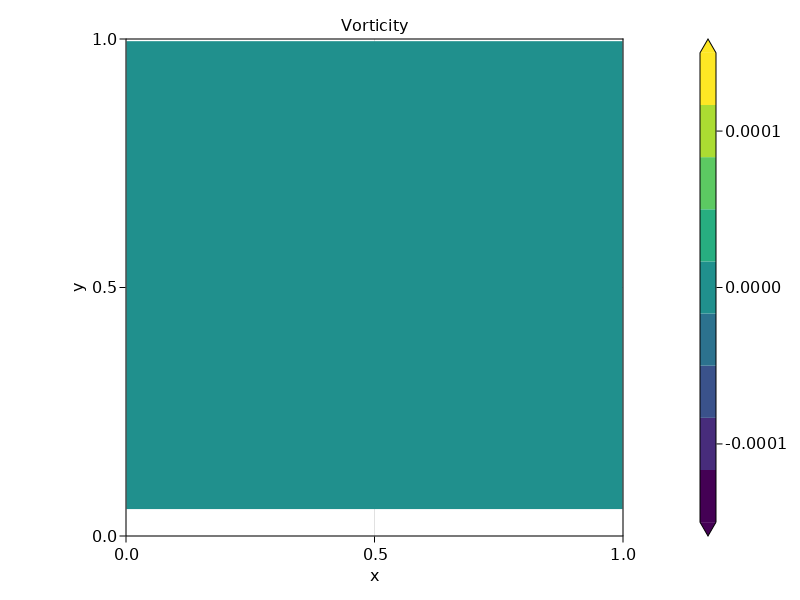

([-2.6663317487281184e-8, -6.548505832322024e-7, -5.588494977825188e-6, -2.6443198834479247e-5, -8.676356581310368e-5, -0.0002218883123481047, -0.0004733680817804473, -0.0008797014895013994, -0.0014674058419639595, -0.002246543663087801  …  -0.003071527962413536, -0.004522285907159682, -0.006679100461600577, -0.010377474602776899, -0.017953701122539804, -0.03682804237081582, -0.10424256724810557, -0.2757622392843944, -0.3610199684515968, -0.12112144513859001], [-0.058175211677769935, -0.05817539811446848, -0.05817621863590666, -0.05817845715270535, -0.05818302248023997, -0.05819067411560269, -0.05820176072169524, -0.05821607062922555, -0.058232865536485816, -0.05825108297429939  …  0.03280107692205385, 0.07862204498958296, 0.13641958703916965, 0.2080676418259429, 0.2979302050957645, 0.4166552959945398, 0.589330023082352, 0.8597121335019657, 1.2065607584409235, 1.4777465813925283])

In [17]:
V, p = @time solve(problem, RK44(); Δt = 0.001, processors)

## Postprocess

The `tracer` object contains a history of some quantities related to the momentum and
energy.

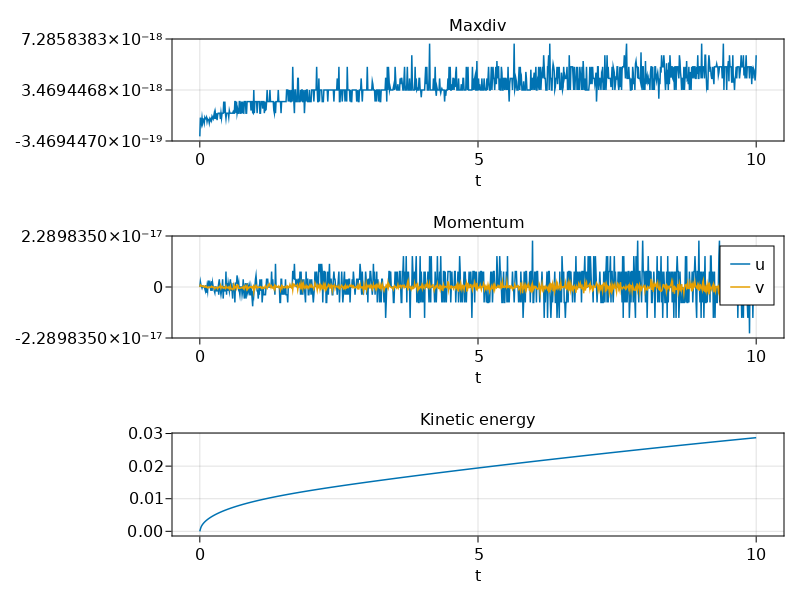

In [18]:
plot_tracers(tracer)

We may also plot the final pressure field,

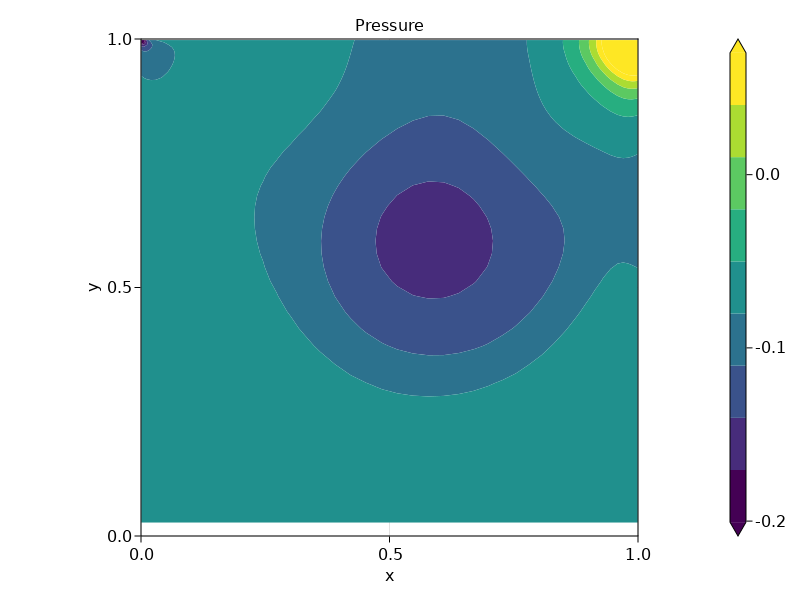

In [19]:
plot_pressure(setup, p)

velocity field,

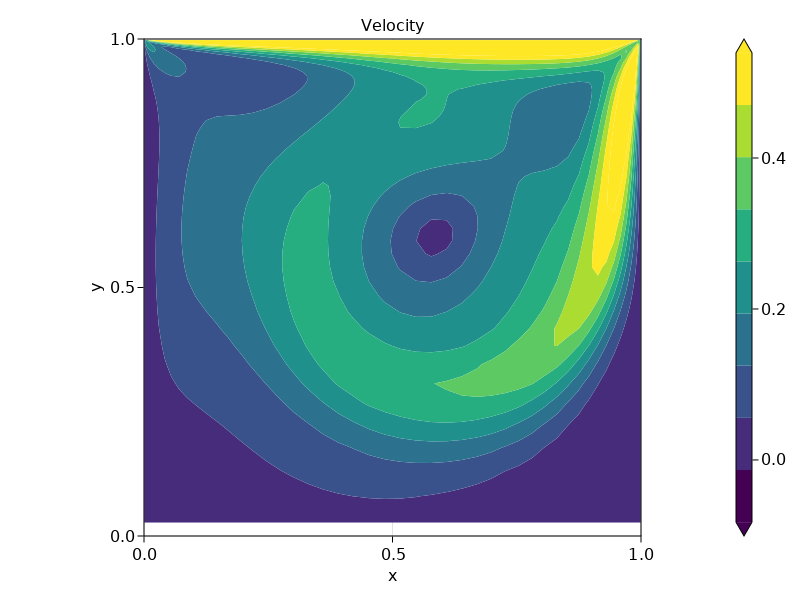

In [20]:
plot_velocity(setup, V, t_end)

vorticity field,

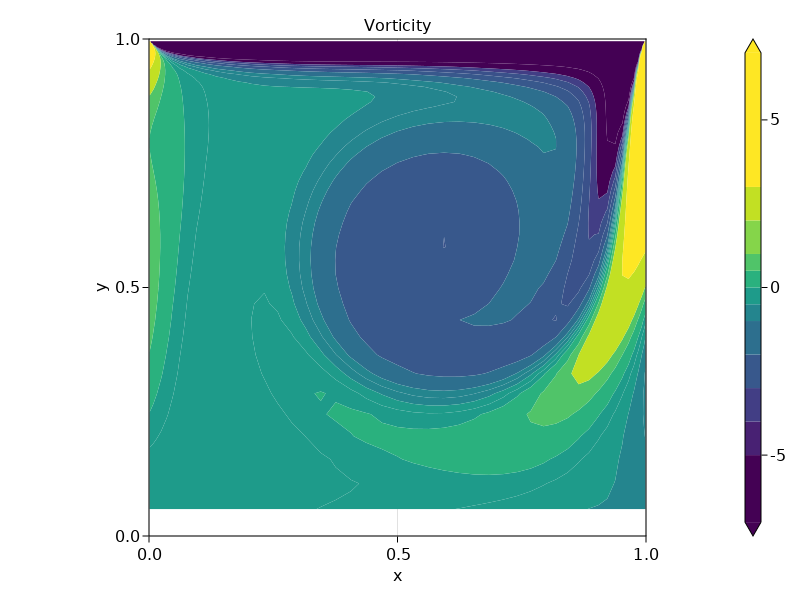

In [21]:
levels = [-7, -5, -4, -3, -2, -1, -0.5, 0, 0.5, 1, 2, 3, 7]
plot_vorticity(setup, V, tlims[2]; levels)

or streamfunction.

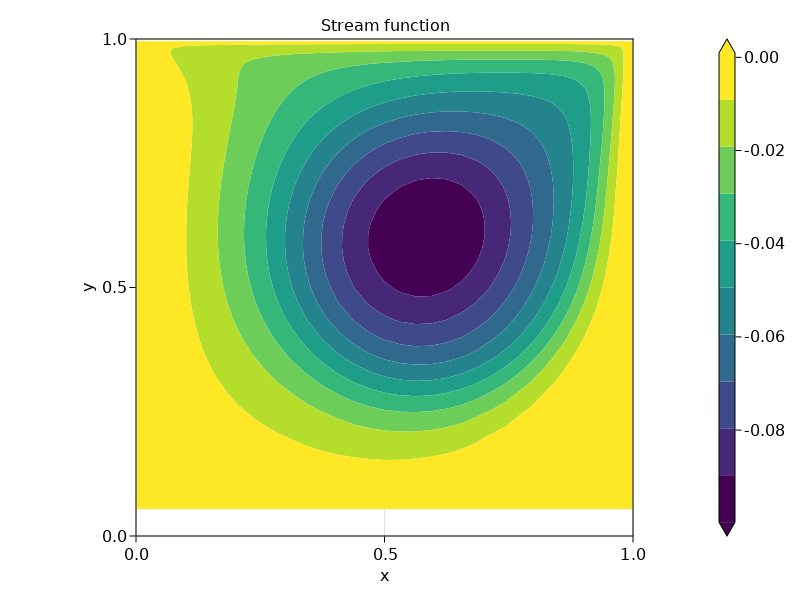

In [22]:
plot_streamfunction(setup, V, tlims[2])

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*